In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:
import plotly
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objs as go
pyo.init_notebook_mode()

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
dataset = pd.read_csv("data/weatherAUS.csv")

# Rain in Australia

In [6]:
dataset.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

**Размер датасета**

In [7]:
dataset.shape

(145460, 23)

**Названия столбцов**

In [8]:
columns = dataset.columns
columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## Анализ предсказываемой переменной

**Проверка переменной на нулевые значения**

In [9]:
dataset['RainTomorrow'].isnull().sum()

3267

**Удаление строк с нулевыми значениями**

In [10]:
dataset_nan = dataset.iloc[dataset[dataset['RainTomorrow'].isnull()].index]
print(len(dataset_nan))
dataset = dataset.drop(dataset[dataset['RainTomorrow'].isnull()].index)

3267


**Количество уникальных значений**

In [11]:
dataset['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

**График соотношения значений переменной RainTomorrow**

In [12]:
count = pd.DataFrame(dataset['RainTomorrow'].value_counts())
fig = px.pie(count, values = 'RainTomorrow', names = ['No','Yes'],
            color_discrete_sequence=['#B4DBE9', '#D0F0C0']
            )
fig.update_layout(
    font_family = 'monospace',
    title=dict(text='Rain tomorrow', x=0.5,y=0.98,
               font=dict(size=20)),
    )
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.show()

**Распределение частоты**

In [13]:
dataset['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Для удобства использования нужно заменить 'Yes' и 'No' на 1 и 0.

In [14]:
dataset.loc[dataset['RainTomorrow'] == 'Yes', 'RainTomorrow'] = 1
dataset.loc[dataset['RainTomorrow'] == 'No', 'RainTomorrow'] = 0
dataset['RainTomorrow'].value_counts()

0    110316
1     31877
Name: RainTomorrow, dtype: int64

**Результат**
- Датасет содержал 3267 строк с неопределенным значением, они были сохранены в отдельную переменную и удалены из датасета.
- Переменная содержит два уникальных значения - 'Yes' и 'No'
- Уникальные значения находятся в процентном соотношении 22.4 % и 77.6%.
- Количество значений Yes 31877, No 110316.
- Значения были заменены на 1 и 0.

## Анализ всех переменных

**Удаление незначимых переменных**

In [15]:
dataset.pop('Date')
dataset.pop('Location')
dataset.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0     13.4     22.9       0.6          NaN       NaN           W   
1      7.4     25.1       0.0          NaN       NaN         WNW   
2     12.9     25.7       0.0          NaN       NaN         WSW   
3      9.2     28.0       0.0          NaN       NaN          NE   
4     17.5     32.3       1.0          NaN       NaN           W   

   WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity9am  \
0           44.0          W        WNW          20.0  ...         71.0   
1           44.0        NNW        WSW           4.0  ...         44.0   
2           46.0          W        WSW          19.0  ...         38.0   
3           24.0         SE          E          11.0  ...         45.0   
4           41.0        ENE         NW           7.0  ...         82.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         22.0       1007.7       1007.1       8.0       NaN     16.9   
1         25.0       1010.6       1007.8       NaN       NaN     17.2   
2         30.0       1007.6       1008.7       NaN       2.0     21.0   
3         16.0       1017.6       1012.8       NaN       NaN     18.1   
4         33.0       1010.8       1006.0       7.0       8.0     17.8   

   Temp3pm  RainToday RainTomorrow  
0     21.8         No            0  
1     24.3         No            0  
2     23.2         No            0  
3     26.5         No            0  
4     29.7         No            0  

[5 rows x 21 columns]

In [16]:
columns = dataset.columns
columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

**Количество нулевых значений**

In [17]:
dataset.isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

Можно видеть, что все переменные содержат нулевые значения.

**Типы переменных**

In [18]:
dataset.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow       int64
dtype: object

В датасете содержатся стролбцы с различными типами данных, необходимо выделить количественные и качественные переменные.

**Количество качественных переменных**

In [19]:
categorical = [var for var in columns if dataset[var].dtype=='object']
print('Датасет содержит', len(categorical), 'качественных переменных:\n', categorical)

Датасет содержит 4 качественных переменных:
 ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


**Количество количественных переменных**

In [20]:
numerical = [var for var in columns if dataset[var].dtype=='float64']
print('Датасет содержит', len(numerical), 'количественных переменных:\n', numerical)

Датасет содержит 16 количественных переменных:
 ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


### Анализ качественных переменных

Датасет содержит 4 качественных переменных. Здесь представлено 4 графика, показывающие количество наблюдений для каждой категории переменной и их названия. График для переменной 'RainTomorrow' представлен выше.

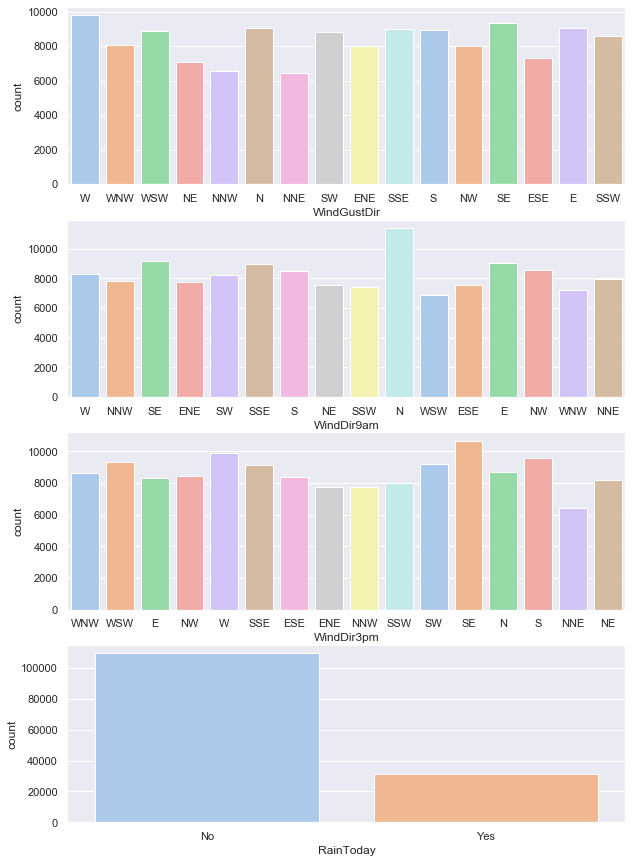

In [21]:
sns.set(font_scale=1)
f, axes = plt.subplots(4, 1, figsize=(10, 15))
for i in range(4):
    sns.countplot(x=categorical[i], palette="pastel", data=dataset, ax=axes[i])

**Количество категорий в каждой переменной**

In [22]:
for cat in categorical:
    print(dataset[cat].value_counts(), '\n')

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64 

N      11393
SE      9162
E       9024
SSE     8966
NW      8552
S       8493
W       8260
SW      8237
NNE     7948
NNW     7840
ENE     7735
ESE     7558
NE      7527
SSW     7448
WNW     7194
WSW     6843
Name: WindDir9am, dtype: int64 

SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: WindDir3pm, dtype: int64 

No     109332
Yes     31455
Name: RainToday, dtype: int64 



**Распределение категорий в каждой переменной**

In [23]:
for cat in categorical:
    print(dataset[cat].value_counts()/len(dataset)*100, '\n')

W      6.877976
SE     6.546736
E      6.379358
N      6.352633
SSE    6.324503
S      6.293559
WSW    6.259802
SW     6.186662
SSW    6.055150
WNW    5.672572
NW     5.628266
ENE    5.620530
ESE    5.137384
NE     4.965083
NNW    4.614151
NNE    4.524133
Name: WindGustDir, dtype: float64 

N      8.012349
SE     6.443355
E      6.346304
SSE    6.305514
NW     6.014361
S      5.972868
W      5.809006
SW     5.792831
NNE    5.589586
NNW    5.513633
ENE    5.439790
ESE    5.315311
NE     5.293510
SSW    5.237951
WNW    5.059321
WSW    4.812473
Name: WindDir9am, dtype: float64 

SE     7.498963
W      6.970104
S      6.749981
WSW    6.560801
SW     6.457421
SSE    6.429290
N      6.095237
WNW    6.087501
NW     5.955286
ESE    5.894805
E      5.866674
NE     5.741492
SSW    5.633189
NNW    5.438383
ENE    5.432054
NNE    4.531869
Name: WindDir3pm, dtype: float64 

No     76.889861
Yes    22.121342
Name: RainToday, dtype: float64 



**Преобразование переменной RainToday аналогично RainTomorrow**

In [24]:
dataset.loc[dataset['RainToday'] == 'Yes', 'RainToday'] = 1
dataset.loc[dataset['RainToday'] == 'No', 'RainToday'] = 0
dataset['RainToday'].value_counts()

0    109332
1     31455
Name: RainToday, dtype: int64

**Заполнение нулевых значений переменной RainToday**

Так как нулевых значений немного, они были заполнены 0.

In [25]:
dataset['RainToday'].isnull().sum()

1406

In [26]:
dataset['RainToday'].fillna(0, inplace=True)
dataset['RainToday'].isnull().sum()

0

### Анализ количественных переменных

**Распределение данных по предсказываемой переменной RainTomorrow**

Так как данные распределены в процентном соотношении 30 к 70, то будет создан датасет с распределением 50 на 50 для составления графиков.

In [27]:
dataset_with_1 = dataset.loc[dataset['RainTomorrow']==1]
len(dataset_with_1)

31877

In [28]:
dataset_with_0 = dataset.loc[dataset['RainTomorrow']==0]
dataset_with_0 = dataset_with_0.dropna()
frac = len(dataset_with_1)/len(dataset_with_0)
dataset_with_0 = dataset_with_0.sample(frac=frac)
dataset_with_0.shape

(31877, 21)

In [29]:
dataset_ = pd.concat([dataset_with_0, dataset_with_1]).sample(frac=1)

На данных графиках видно распределение каждой переменной для 0 и 1.

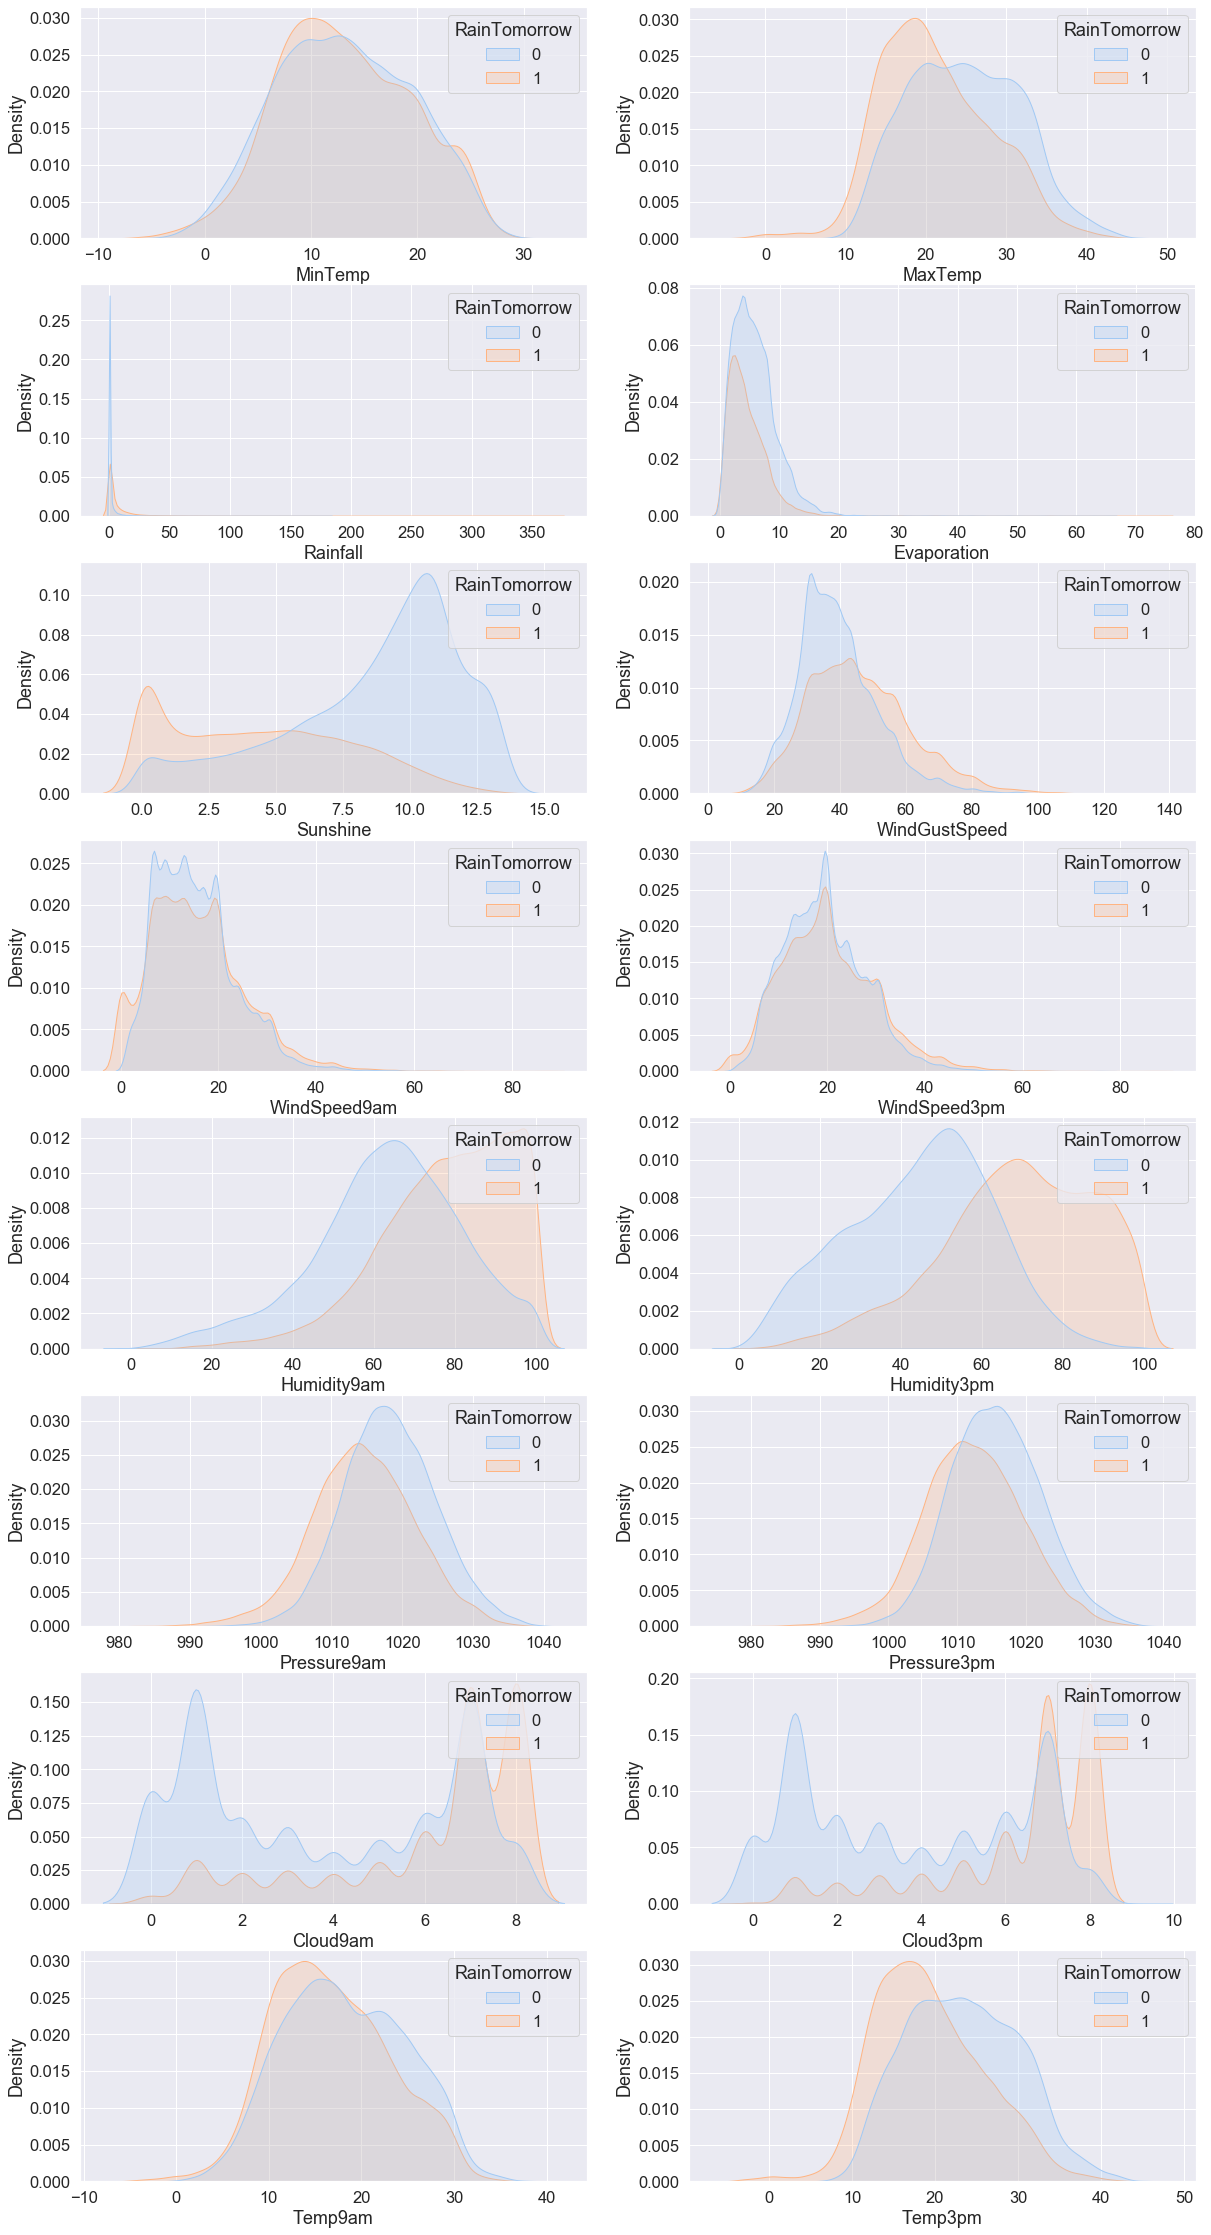

In [30]:
sns.set(font_scale=1.5)
f, axes = plt.subplots(8, 2, figsize=(20, 40))
val = 0
for i in range(8):
    for j in range(2):
        sns.kdeplot(data = dataset_, x=numerical[val], hue='RainTomorrow', fill=True, ax=axes[i, j], palette="pastel")
        val+=1

**Распределение данных**

Составлен график распределения без разделения по значениям RainTomorrow.

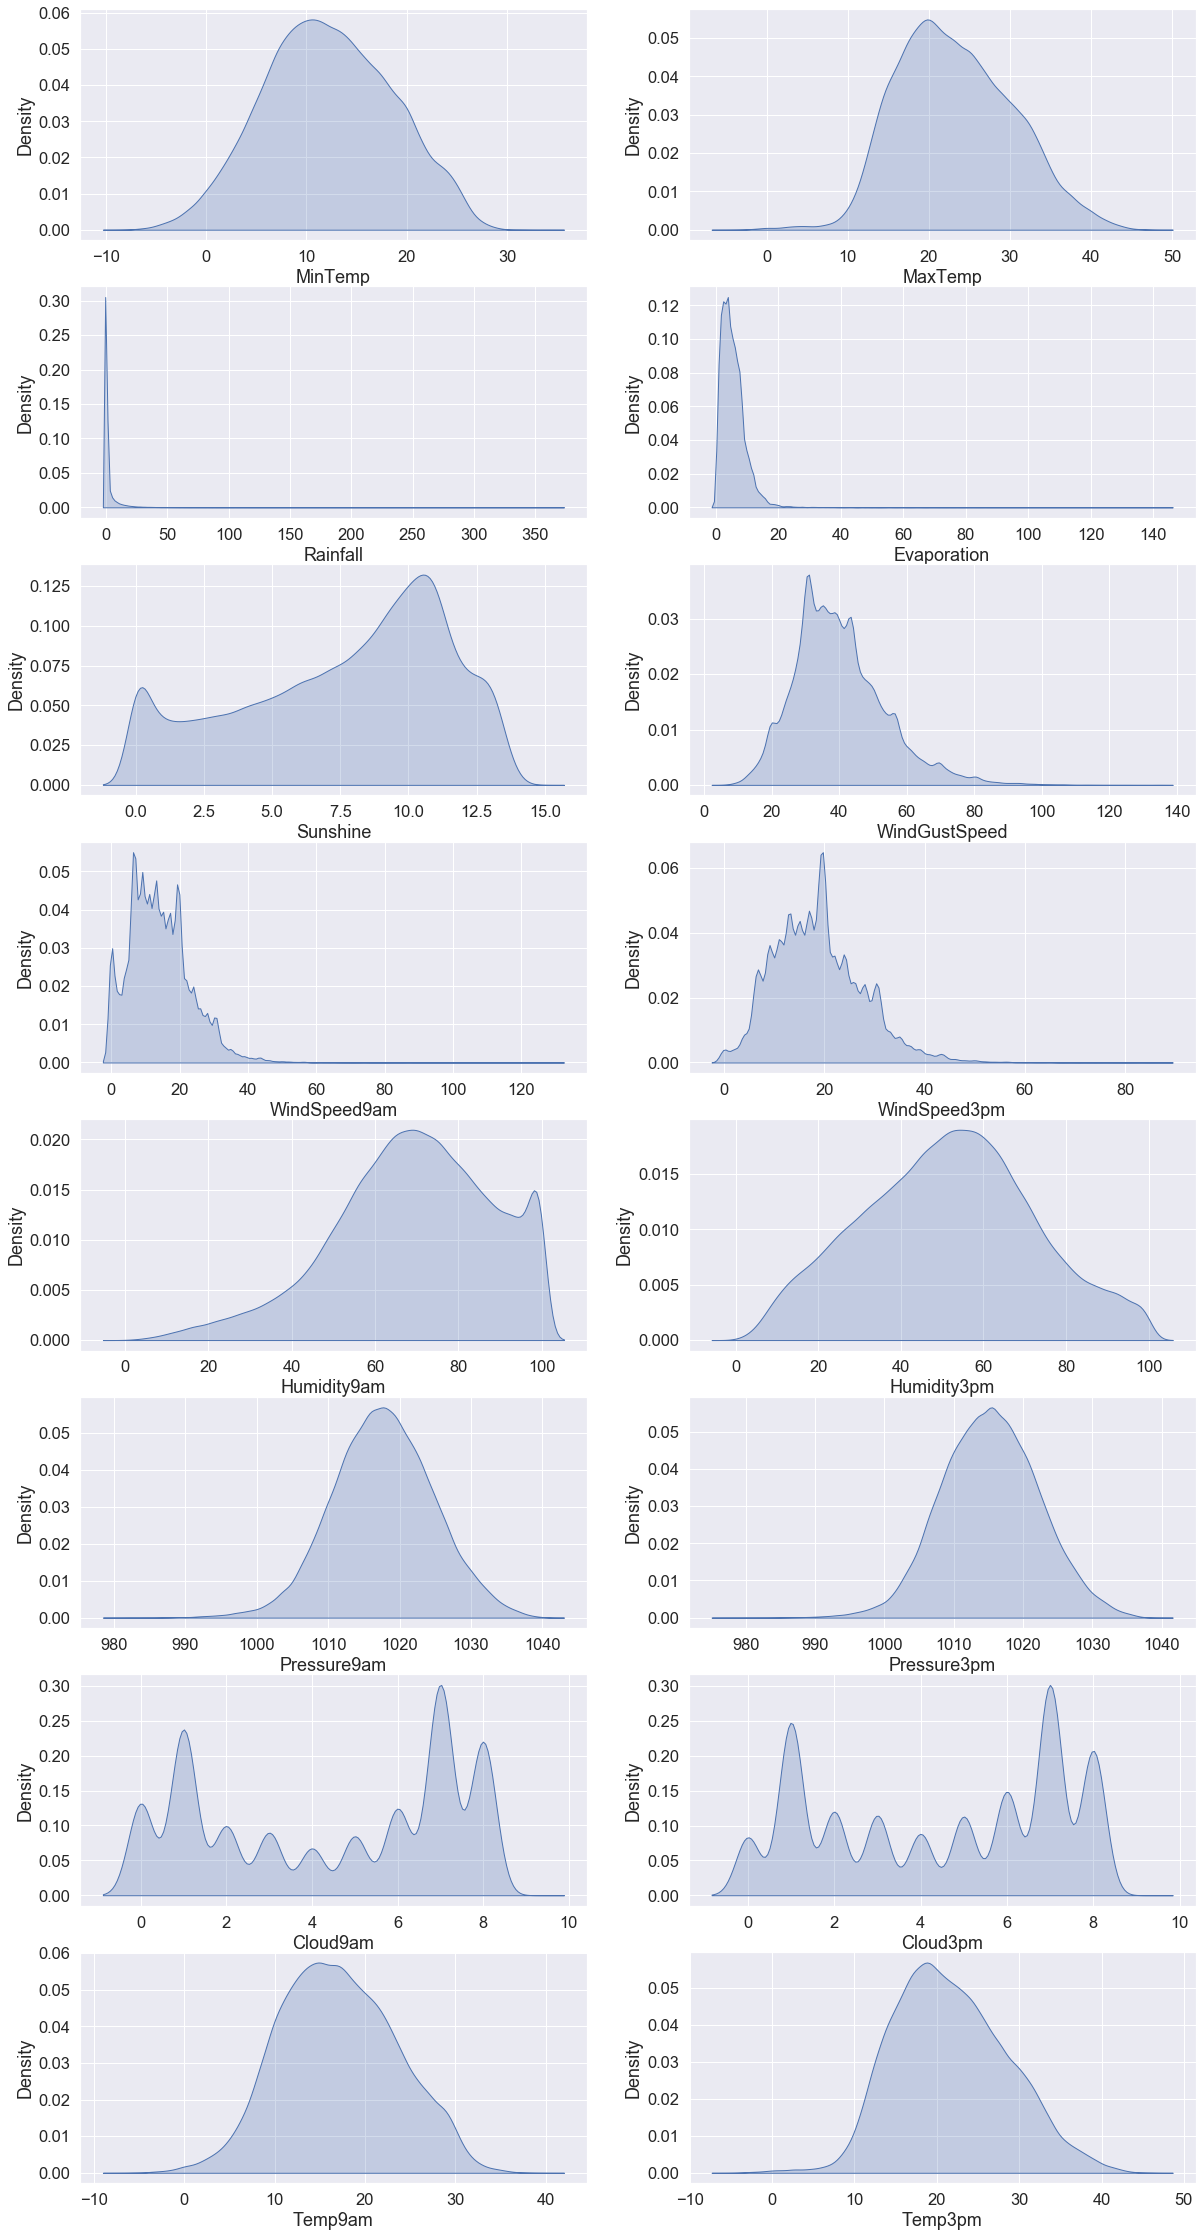

In [31]:
sns.set(font_scale=1.5)
f, axes = plt.subplots(8, 2, figsize=(20, 40))
val = 0
for i in range(8):
    for j in range(2):
        sns.kdeplot(data = dataset, x=numerical[val], fill=True, ax=axes[i, j], palette="pastel")
        val+=1
                

**Заполнение нулевых значений**

Я заполню нулевые значения медианой, так как есть переменные с выбросами.

In [32]:
for num in numerical:
    median = dataset[num].median()
    dataset[num].fillna(median, inplace=True)
    
dataset[numerical].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

### График корреляции

Text(0.5, 1, 'Корреляция между признаками')

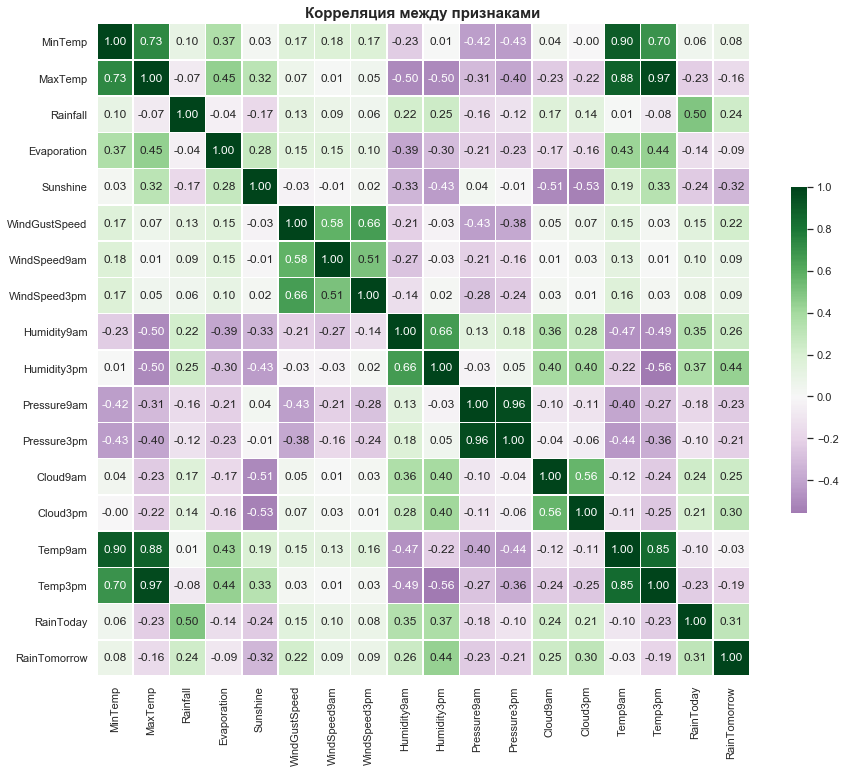

In [33]:
sns.set(font_scale=1)
plt.figure(figsize=(15,12))
corr = dataset.corr(method='pearson') 
sns.heatmap(corr, annot=True, fmt='.2f', cmap='PRGn', vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(18, 0))
plt.title("Корреляция между признаками", size=15, weight='bold')

На графике корреляции видно, что в основном все переменные либо не коррелируют между собой, либо коррелируют немного. 

Но это за исключением пеменных 'MinTemp', 'MaxTemp' и 'Temp9am','Temp3pm'. Эти пары переменных коррелируют между собой на 0.9, 0.97, 0.71, 0.88. Поэтому одну их пар можно удалить, потому что они в сущности несут в себе похожие данные.

'MinTemp' и 'MaxTemp' коррелируют между собой на 0,73.

'Temp9am' и 'Temp3pm' коррелируют между собой на 0,85.

In [34]:
#Restore the rc params from Matplotlib's internal default style
plt.rcdefaults()

**Создание датасета с One Hot Encoding**

In [35]:
dataset_dummies = pd.get_dummies(dataset.drop(['RainTomorrow'], axis = 1), dummy_na=True)
dataset_dummies.head()

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     13.4     22.9       0.6          4.8       8.5           44.0   
1      7.4     25.1       0.0          4.8       8.5           44.0   
2     12.9     25.7       0.0          4.8       8.5           46.0   
3      9.2     28.0       0.0          4.8       8.5           24.0   
4     17.5     32.3       1.0          4.8       8.5           41.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  WindDir3pm_NW  \
0          20.0          24.0         71.0         22.0  ...              0   
1           4.0          22.0         44.0         25.0  ...              0   
2          19.0          26.0         38.0         30.0  ...              0   
3          11.0           9.0         45.0         16.0  ...              0   
4           7.0          20.0         82.0         33.0  ...              1   

   WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  WindDir3pm_SW  \
0             0              0               0               0              0   
1             0              0               0               0              0   
2             0              0               0               0              0   
3             0              0               0               0              0   
4             0              0               0               0              0   

   WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  WindDir3pm_nan  
0             0               1               0               0  
1             0               0               1               0  
2             0               0               1               0  
3             0               0               0               0  
4             0               0               0               0  

[5 rows x 68 columns]

In [36]:
feature_names = list(dataset_dummies.columns)

## Изучение важности критериев

In [37]:
x, y = dataset_dummies.iloc[:,:], dataset.iloc[:,-1]

**Использование RandomForestClassifier для составления графика важности критериев**

Text(0.5, 1.0, 'RandomForestClassifier feature importances')

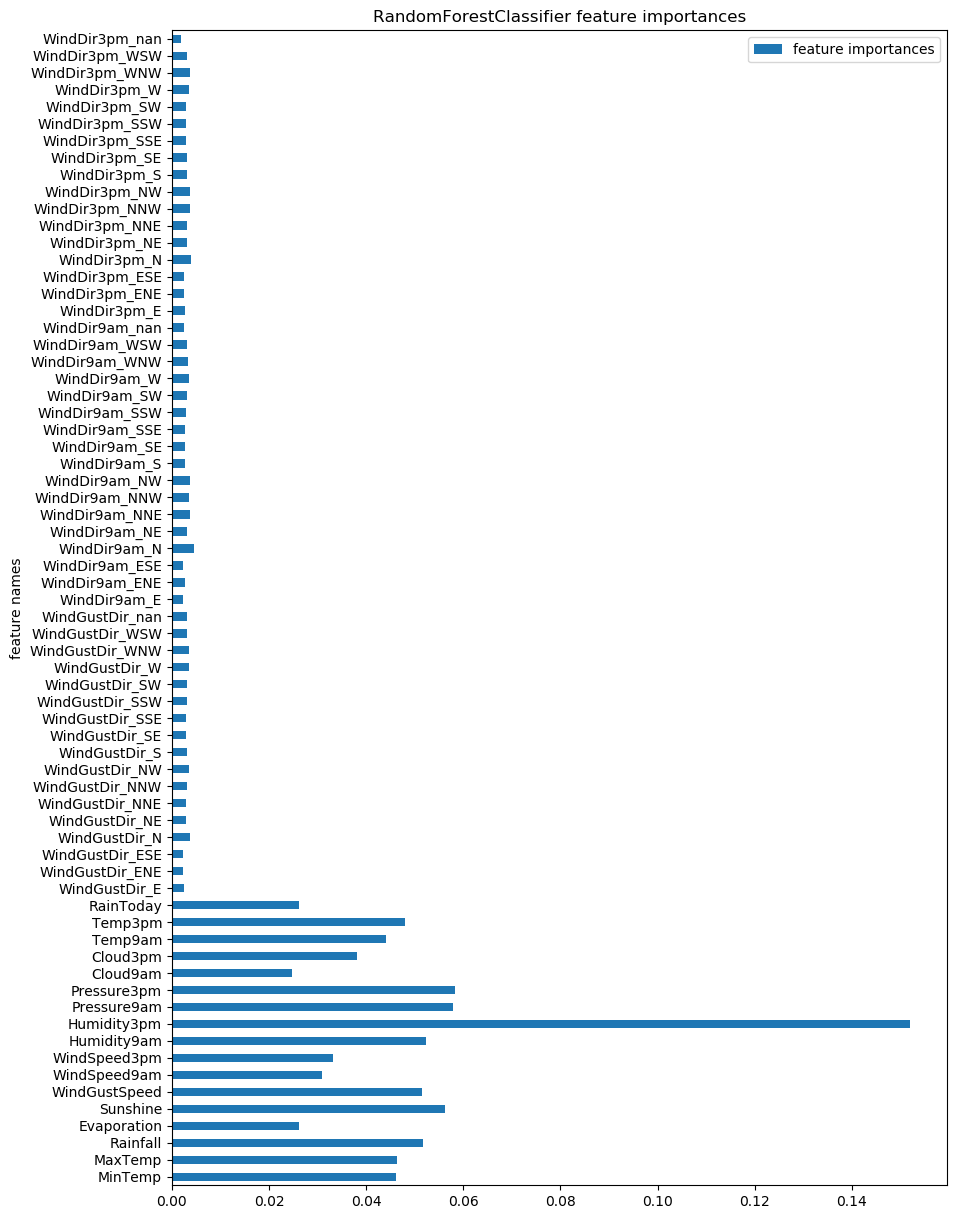

In [38]:
forest = RandomForestClassifier()
forest.fit(x, y)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'feature importances':forest.feature_importances_})
df_to_plot.plot.barh(x='feature names', y='feature importances', figsize=(10, 15))
plt.title('RandomForestClassifier feature importances')

На графике можно увидеть, что из количественных переменных, следующие переменные являются наиболее значимыми:
- Sunshine
- WindGustSpeed
- Humidity9am
- Humidity3pm
- Pressure9am
- Pressure3pm

Немного менее значимые критерии:
- MinTemp
- MaxTemp
- Rainfall
- Temp9am
- Temp3pm

## Обучение и предсказание

In [39]:
def make_preprossesor(scaler, categorical_features):
    if (categorical_features):
        preprocessor = ColumnTransformer(transformers=[
        ('num', scaler, selector(dtype_exclude="category")),
        ('cat', OneHotEncoder(handle_unknown='ignore'), selector(dtype_include="category"))])
    else:
        preprocessor = scaler                                 
    return preprocessor

In [40]:
def show_results(estimator, scaler, x, y, categorical_features=False):
    preprocessor = make_preprossesor(scaler, categorical_features)                   
    model = Pipeline(steps=[('preprocessor', preprocessor),('estimator', estimator)])  
                                         
    estimatorScores = cross_val_score(model, x, y)
    print("\nРезультат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=5)
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    print('\nMAE: {:.4f}'.format(mean_absolute_error(y_test, model_pred)))
    print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, model_pred))))   
    #print('R2 {:.4f}'.format(r2_score(y_test, model_pred)))
    return model

In [41]:
def grid_search(estimator, param_grid, scaler, x, y, categorical_features=False):
    preprocessor = make_preprossesor(scaler, categorical_features)                              
    model = Pipeline(steps=[('preprocessor', preprocessor),('estimator', estimator)])
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=5)
    grid_search = GridSearchCV(model, param_grid)
    grid_search.fit(X_train, y_train)
    print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
    print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
    return grid_search

### LogisticRegression

LogisticRegression L1

Результат перекрестной проверки: [0.83153416 0.82379831 0.84257534 0.84647303 0.849251  ]
Средняя правильность перекрестной проверки: 0.839

MAE: 0.1557
RMSE: 0.3946


Text(0.5, 1.0, 'LogisticRegression L1')

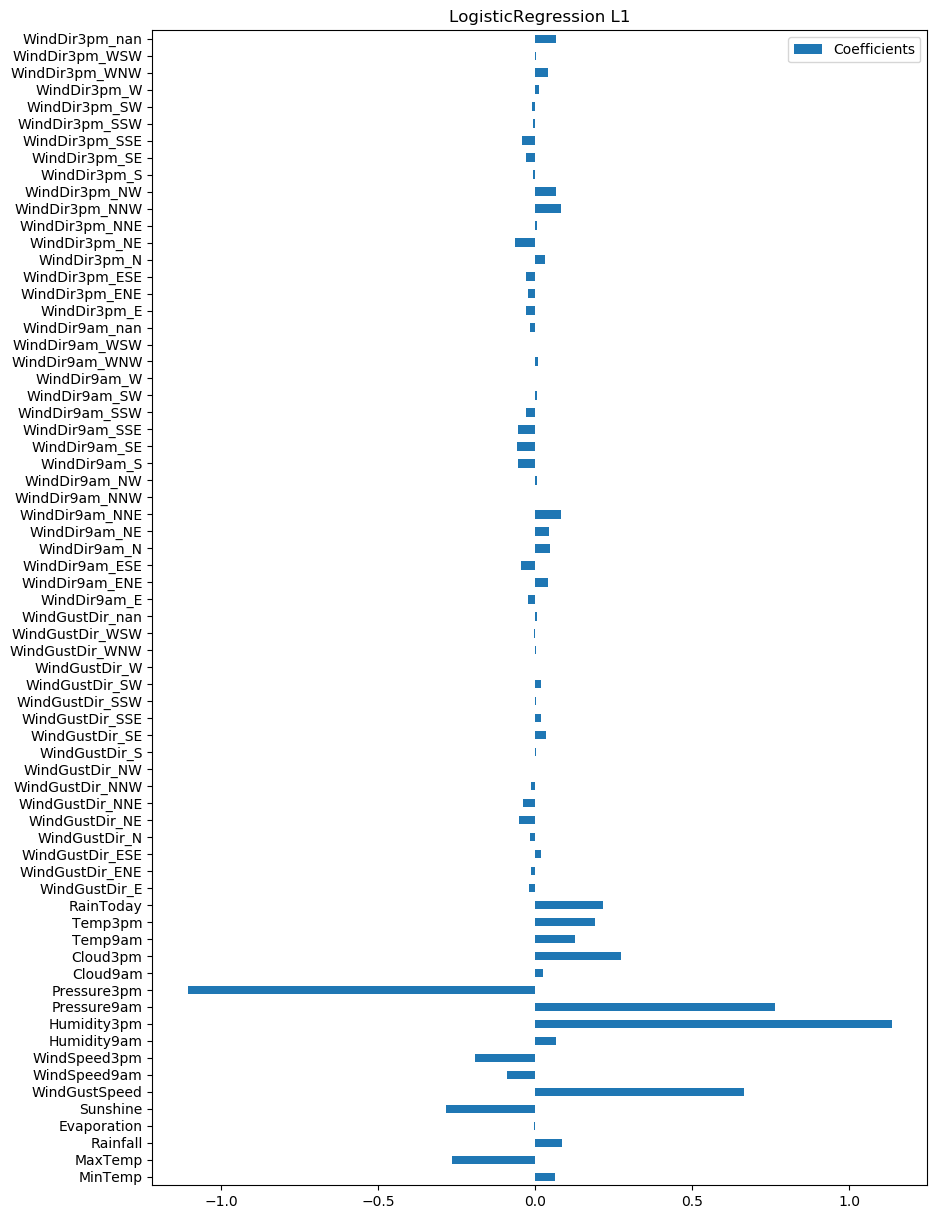

In [150]:
print("LogisticRegression L1")
log_l1 = show_results(LogisticRegression(penalty="l1", solver='saga'), StandardScaler(), x, y)
coefs_l1 = pd.DataFrame(
    log_l1.named_steps['estimator'].coef_.reshape(68,1),
    columns=['Coefficients'], index=feature_names
)

coefs_l1.plot(kind='barh', figsize=(10, 15))
plt.title('LogisticRegression L1')

LogisticRegression L2

Результат перекрестной проверки: [0.83142867 0.82379831 0.8426105  0.84647303 0.84921584]
Средняя правильность перекрестной проверки: 0.839

MAE: 0.1556
RMSE: 0.3945


Text(0.5, 1.0, 'LogisticRegression L2')

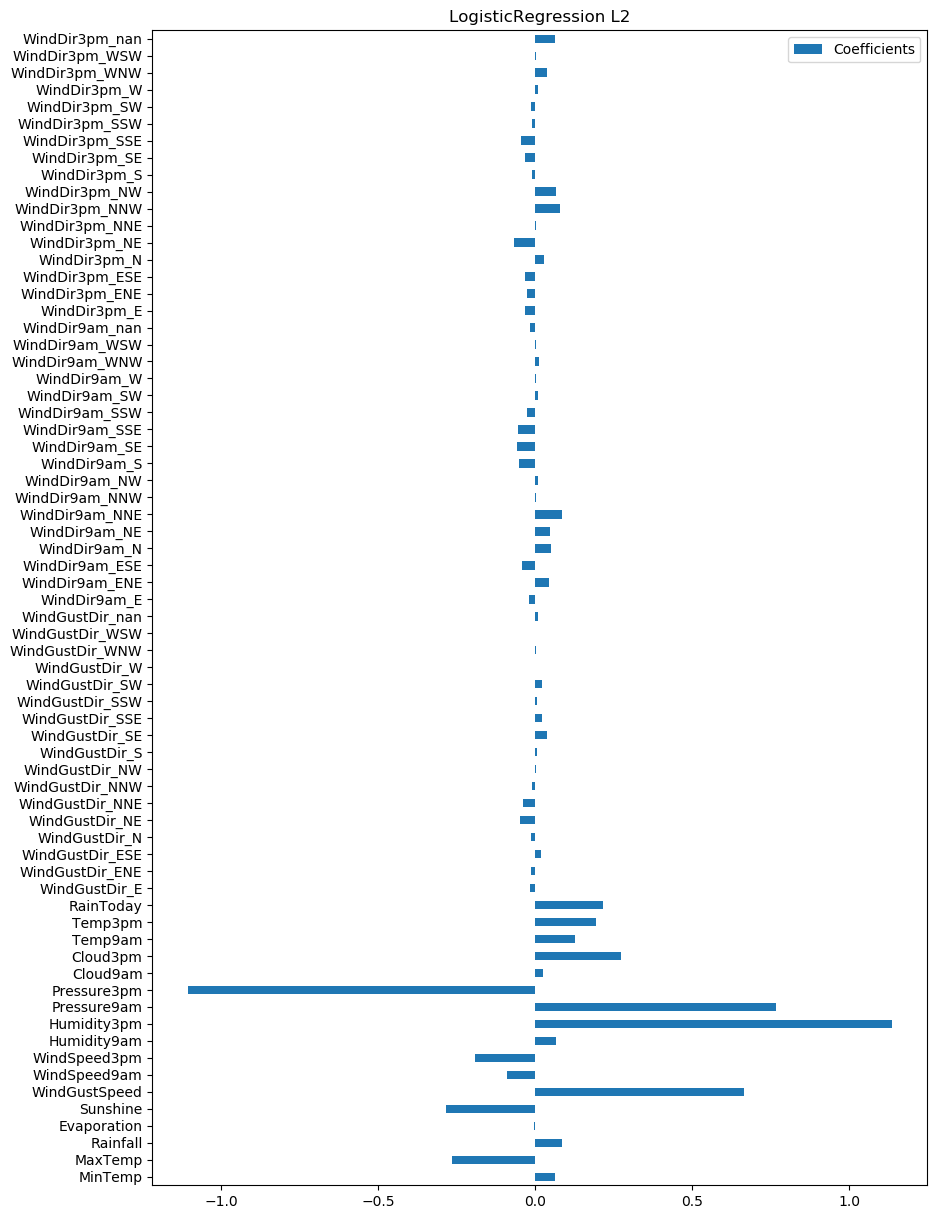

In [162]:
print("LogisticRegression L2")
log_l2 = show_results(LogisticRegression(penalty="l2", solver='saga'), StandardScaler(), x, y)
coefs_l2 = pd.DataFrame(
    log_l2.named_steps['estimator'].coef_.reshape(68,1),
    columns=['Coefficients'], index=feature_names)

coefs_l2.plot(kind='barh', figsize=(10, 15))
plt.title('LogisticRegression L2')

LogisticRegression L1 и L2 показали одинаковые результаты правильности перекрестной проверки и показателей MAE.

In [164]:
print("LogisticRegression L2 без 'Temp9am' и 'Temp3pm'")
log_l1 = show_results(LogisticRegression(penalty="l2", solver='saga'),
                      StandardScaler(),
                      x.drop(['Temp9am','Temp3pm'], axis = 1), y)

LogisticRegression L2 без 'Temp9am' и 'Temp3pm'

Результат перекрестной проверки: [0.83153416 0.82355216 0.84285664 0.84742246 0.84960264]
Средняя правильность перекрестной проверки: 0.839

MAE: 0.1556
RMSE: 0.3944


Удаление 'Temp9am' и 'Temp3pm' не повлияло на показатели регрессии.

In [52]:
param_grid = {
    'estimator__l1_ratio': [0, 0.2, 0.5, 0.7, 1]}
gsCV = grid_search(LogisticRegression(penalty="elasticnet", solver='saga'), 
                   param_grid, 
                   StandardScaler(), 
                   x, y)

Правильность на тестовом наборе: 0.84
Наилучшие значения параметров: {'estimator__l1_ratio': 0}


Также было протестировано с помощью GridSearch использование elasticnet, но результат получился равен 0, что эквивалентно использованию L2. 

### GradientBoostingClassifier

In [45]:
print('GradientBoostingClassifier')
grad_boost = show_results(
        GradientBoostingClassifier(n_estimators = 20),
        StandardScaler(),
        x, y)

GradientBoostingClassifier

Результат перекрестной проверки: [0.83712507 0.82889694 0.84078202 0.83585344 0.83831493]
Средняя правильность перекрестной проверки: 0.836

MAE: 0.1608
RMSE: 0.4010


In [50]:
print('GradientBoostingClassifier c RandomForestClassifier')
grad_boost_forest = show_results(
        GradientBoostingClassifier(init = RandomForestClassifier(), n_estimators = 10),
        StandardScaler(),
        x, y)

GradientBoostingClassifier c RandomForestClassifier

Результат перекрестной проверки: [0.84239952 0.83276487 0.84486093 0.85027076 0.84777411]
Средняя правильность перекрестной проверки: 0.844

MAE: 0.1459
RMSE: 0.3819


### Naive Bayes

In [46]:
param_grid = {
    'estimator__alpha': [0, 0.2, 0.5, 0.7, 1]}
gsCV = grid_search(BernoulliNB(), 
                   param_grid, 
                   StandardScaler(), 
                   x, y)

Правильность на тестовом наборе: 0.79
Наилучшие значения параметров: {'estimator__alpha': 1}


In [48]:
print('BernoulliNB')
est = show_results(
        BernoulliNB(alpha=1), 
        StandardScaler(), 
        x, y)

BernoulliNB

Результат перекрестной проверки: [0.79313619 0.77144063 0.74879567 0.80009143 0.80898797]
Средняя правильность перекрестной проверки: 0.784

MAE: 0.2123
RMSE: 0.4607


In [49]:
print('GaussianNB')
est = show_results(
        GaussianNB(), 
        StandardScaler(), 
        x, y)

GaussianNB

Результат перекрестной проверки: [0.70399803 0.63792679 0.69285137 0.75061537 0.77406991]
Средняя правильность перекрестной проверки: 0.712

MAE: 0.2689
RMSE: 0.5185


## Вывод
Лучшей моделью среди выше использованных оказалась модель GradientBoostingClassifier с использованием RandomForestClassifier. Средний результат перекрестной проверки равен 0.844, средняя абсолютная ошибка равна 0.1459, а среднеквадратичное отклонение 0.3819.

Данную модель можно улучшить подбором различных параметров с помощью GridSearch.

Важность количественных критериев модели GradientBoostingClassifier с использованием RandomForestClassifier представлена ниже. Наиболее важные критерии по оценке модели - это Humidity3pm и WindGustSpeed.

Также были получены высокие показатели логистической регрессии с L2, равные 0,84.

Оценка критериев регрессии совпадает с оценкой RandomForestClassifier, приведенной в разделе изучения критериев. Выделенные моделями признаки:
- Sunshine
- WindGustSpeed
- Humidity9am
- Humidity3pm
- Pressure9am
- Pressure3pm


Text(0.5, 1.0, 'Количественные критерии GradientBoostingClassifier c RandomForestClassifier')

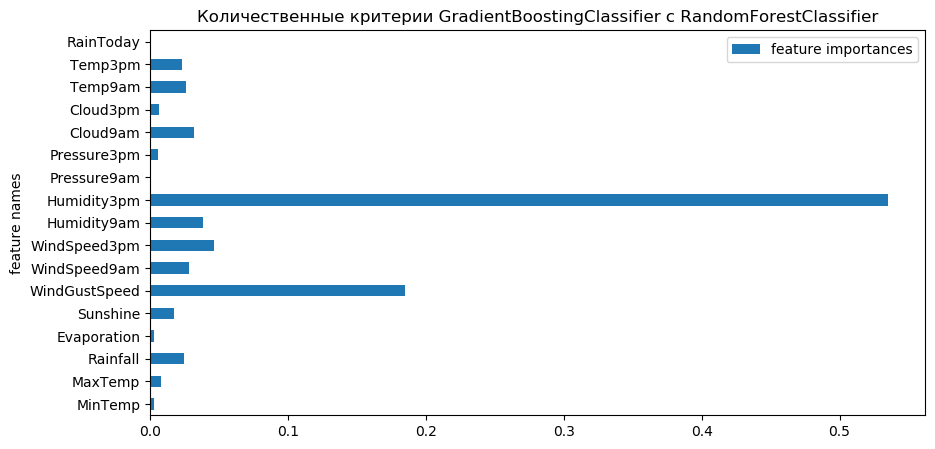

In [71]:
pd.DataFrame({
    'feature names':feature_names[:17], 
    'feature importances':grad_boost_forest.named_steps['estimator'].feature_importances_[:17]}).plot.barh(
    x='feature names', 
    y='feature importances', 
    figsize=(10, 5))
plt.title('Количественные критерии GradientBoostingClassifier c RandomForestClassifier')

Далее представлена оценка качественных критериев моделью GradientBoostingClassifier c RandomForestClassifier.

Text(0.5, 1.0, 'Качественные критерии GradientBoostingClassifier c RandomForestClassifier')

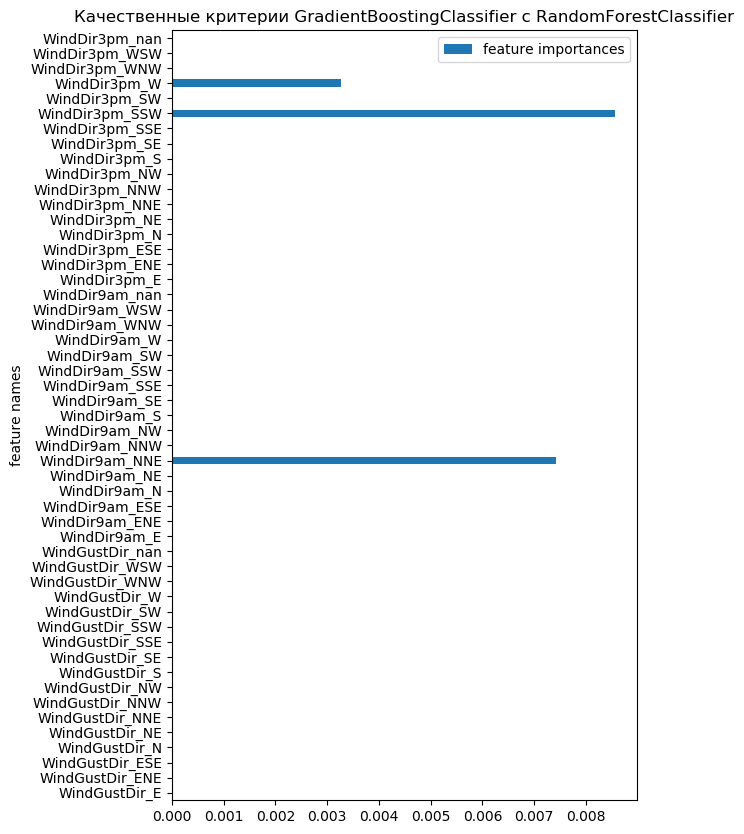

In [72]:
pd.DataFrame({
    'feature names':feature_names[17:], 
    'feature importances':grad_boost_forest.named_steps['estimator'].feature_importances_[17:]}).plot.barh(
    x='feature names', 
    y='feature importances', 
    figsize=(6, 10))
plt.title('Качественные критерии GradientBoostingClassifier c RandomForestClassifier')